In [1]:
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import levy
from scipy.stats import pareto
from numba import jit
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline

 In the paper, the Monte Carlo simulations show that the median h = 12%.
 - $ \sigma_{GDP} = h\sigma $
 
 - Proposition 2:
 $$ \sigma_{GDP} \sim \frac{\nu_{\zeta}} {\ln{N}} \sigma $$
 
 $\nu_{\zeta}$ is the square root of a stable Levy distribution with exponent $\zeta/2$

In [10]:
σ_π = 0.12
a = 1
ζ = 1  # Zipf's law
x0 = a**(1/ζ)
N = 1000000
sim = 1000

Use Proposition 2 to find h directly.

In [5]:
rvs = levy_stable.rvs(alpha=ζ/2, beta=1, loc=x0, size=N)
h = np.median(np.sqrt(rvs)/np.log(N))
print(h)

0.12938491284027032


Simalate the herfindhl for Pareto distribution. 

$$h = \big[\sum_{i=1}^{N} (\frac{S_{it}}{Y_t})^2\big]^{0.5} $$
$$Y_t = \sum_{i=1}^{N} S_{it} $$

ALso assume $\zeta$ is 1.059 following Axtell(2001).

In [9]:
@njit(parallel=True)
def herfindahl(nSim, ζ, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = (np.random.pareto(ζ, N) + 1) * x0         
        h[i] = np.sqrt(np.sum(np.square(size / np.sum(size))))

    return h    

h = herfindahl(nSim=1000, ζ=1)
print(np.median(h))

h = herfindahl(nSim=1000, ζ=1.059)
print(np.median(h))

0.11809041178079463
0.08390069858522964


Simulate the herfindahl for log-normal.

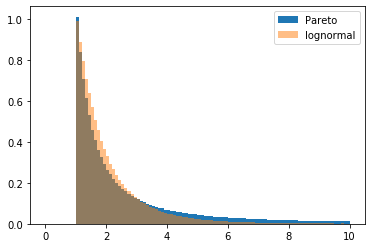

In [13]:
# Find the parameters for lognormal
size = (np.random.pareto(ζ, size=N) + 1)*x0 
plt.hist(size, bins=100, range=(0,10), density=True, label='Pareto')
size = np.random.lognormal(0, 0.77, size=N)
mask = size>1

plt.hist(size[mask], bins=100, range=(0,10), density=True, alpha=.5, label='lognormal')
plt.legend()
plt.show()

Set the shape parameter $\sigma$ for lognormal to be less than one.

In [7]:
@njit(parallel=True)
def h_lognormal(nSim, sigma, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = np.random.lognormal(0, sigma, size=N)        
        mask=size>1
        h[i] = np.sqrt(np.sum(np.square(size[mask] / np.sum(size[mask]))))
    return h    

for s in [0.7, 0.9, 1, 2]:
    h = h_lognormal(nSim=1000, sigma=s)
    print(np.median(h))

0.0016159235500254874
0.0018041457138818467
0.0019366719673537581
0.007049943650016512


Plot the output's distribution. Check Proposition 2.

$$\sigma_{GDP}\ln{N} \overset{d}\rightarrow  \nu_{\zeta} \sigma $$

$\nu_{\zeta}$ is the square root of a stable Levy distribution with exponent $\zeta/2$

Simulate $\sigma_{GDP}$.

In [47]:
@njit(parallel=True)
def GDP_std(nSim, nGDP=100, N=1000000):

    σ_GDP = np.zeros(nSim)
    for i in range(nSim):

        size = (np.random.pareto(ζ, N) + 1) * x0
        σ_GDP[i] = σ_π * np.sqrt(np.sum(np.square(size / np.sum(size))))
#         print('.', end='')

    return σ_GDP


σ_GDP = GDP_std(nSim=sim)
print(σ_GDP)

[0.0408337  0.03691378 0.00565602 ... 0.00948032 0.02980851 0.03239216]


0.01428858041912609


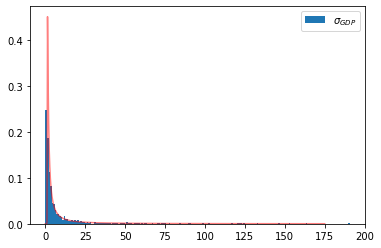

In [48]:
print(np.median(σ_GDP))
plt.hist((σ_GDP*np.log(N)/σ_π)**2, bins=200, label='$\sigma_{GDP}$', density=True)
x = np.linspace(0,175,500)
plt.plot(x, levy_stable.pdf(x, alpha=ζ/2, beta=1, loc=a**(1/ζ)), color='r', alpha=0.5)
plt.legend()
plt.show()

### Conclusion

Under Zipf's law($\zeta=1$), when the firm sizes follow Pareto distribution, the simulated herfindahl is around 11.89%.  While if the firm size is log-normal distributed, the herfindahl is less than 0.2% if the variance of the distribution is less than 1 (similar shapes). 

Thus, given the standard deviation of firm's growth rate ($\sigma=12\%$), the simulated standard deciation of GDP growth rate are around 1.4% for Pareto distributed firm size and less than 0.024% for log-normal distribution. Since the empirically measured macroeconomic fluctuation is around 1%, the log-normal distribution is not reasonable under this model.

This result also follows Proposition 1 which states that 

$$\sigma_{GDP} \sim \frac{(E[S^2])^{0.5}}{E[S]} \frac{\sigma}{\sqrt{N}}$$

where $\frac{\sigma}{\sqrt{N}} = 0.012\%$ under the same assumption.

Therefore, Pareto distribution makes more sense for firm sizes comparing log-normal distribution. 
